### Data Download and Preprocessing - wetland classification
This notebook documents the workflow for downloading, cropping, and preparing data from Google Earth Engine (GEE) and other sources.  
The prepared rasters are saved for use in the classification step.


In [18]:
import ee
import os
import geemap
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
import numpy as np
import math

from scipy.stats import entropy

In [2]:
ee.Initialize(project = "ee-ogalloethel")

In [3]:
# Base directory whee data is stored
base_dir = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data"

# Verify the directory exists
if not os.path.exists(base_dir):
    print(f"WARNING: Base directory does not exist: {base_dir}\nPlease check your path!")
else:
    print(f"Base directory found: {base_dir}")


# Set AOI from shapefile
shapefile = gpd.read_file(os.path.join(base_dir, 'baringo_bbox/baringo_bbox.shp'))
study_area = ee.Geometry(shapefile.geometry[0].__geo_interface__)


Base directory found: C:\Users\Ethel Ogallo\Documents\ZFL1\Data


In [4]:
# Function to read a raster file and return an aligned array
def clip_to_aoi(image):
    """
    Clip an ee.Image to the study_area geometry.
    Args:
        image (ee.Image): The image to clip.
    Returns:   
        ee.Image: The clipped image.
        """
    if not isinstance(image, ee.Image):
        raise TypeError("Input must be an ee.Image")
    return image.clip(study_area)

# Function to export an ee.Image to Google Drive
def export_image_to_drive(image, year, label='image', folder='Exports', scale=30):
    """
    Export an ee.Image to Google Drive.
    Args:
        image (ee.Image): The image to export.
        year (int): The year associated with the image.
        label (str): A label for the exported image.
        folder (str): The folder in Google Drive to save the image.
        scale (int): The scale of the exported image in meters.
    Returns:
        None
    """
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=f'{label}_{year}',
        folder=folder,
        fileNamePrefix=f'{label}_{year}',
        scale=scale,
        region=study_area,
        fileFormat='GeoTIFF',
        maxPixels=1e13
    )
    task.start()
    print(f"Export started: {label}_{year}")



#### Indices

In [7]:
def compute_yearly_ndvi(year):
    start = datetime.date(year, 1, 1)
    end = datetime.date(year + 1, 1, 1)

    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(str(start), str(end))
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.addBands(
              img.normalizedDifference(['B8', 'B4']).rename('NDVI')))
          .select('NDVI'))

    ndvi_min = s2.reduce(ee.Reducer.min()).rename(f'NDVI_Min_{year}')
    ndvi_max = s2.reduce(ee.Reducer.max()).rename(f'NDVI_Max_{year}')
    ndvi_std = s2.reduce(ee.Reducer.stdDev()).rename(f'NDVI_SD_{year}')

    return ndvi_min, ndvi_max, ndvi_std

# ----------------------------
# Loop over years 2018-2024 
# ----------------------------
for year in range(2018, 2024):
    print(f"Processing NDVI stats for {year}...")
    ndvi_min, ndvi_max, ndvi_std = compute_yearly_ndvi(year)

    export_image_to_drive(ndvi_min, year, label='NDVI_Min', folder='NDVI')
    export_image_to_drive(ndvi_max, year, label='NDVI_Max', folder='NDVI')
    #export_image_to_drive(ndvi_std, year, label='NDVI_SD', folder='NDVI')

Processing NDVI stats for 2018...
Export started: NDVI_Min_2018
Export started: NDVI_Max_2018
Processing NDVI stats for 2019...
Export started: NDVI_Min_2019
Export started: NDVI_Max_2019
Processing NDVI stats for 2020...
Export started: NDVI_Min_2020
Export started: NDVI_Max_2020
Processing NDVI stats for 2021...
Export started: NDVI_Min_2021
Export started: NDVI_Max_2021
Processing NDVI stats for 2022...
Export started: NDVI_Min_2022
Export started: NDVI_Max_2022
Processing NDVI stats for 2023...
Export started: NDVI_Min_2023
Export started: NDVI_Max_2023


In [8]:
def compute_yearly_bsi(year):
    start = datetime.date(year, 1, 1)
    end = datetime.date(year + 1, 1, 1)

    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(str(start), str(end))
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.addBands(
              img.expression(
                  '((SWIR + RED) - (NIR + BLUE)) / ((SWIR + RED) + (NIR + BLUE))',
                  {
                      'SWIR': img.select('B11'),
                      'RED': img.select('B4'),
                      'NIR': img.select('B8'),
                      'BLUE': img.select('B2')
                  }
              ).rename('BSI')))
          .select('BSI'))

    bsi_min = s2.reduce(ee.Reducer.min()).rename(f'BSI_Min_{year}')
    bsi_max = s2.reduce(ee.Reducer.max()).rename(f'BSI_Max_{year}')
    bsi_std = s2.reduce(ee.Reducer.stdDev()).rename(f'BSI_SD_{year}')

    return bsi_min, bsi_max, bsi_std


# Compute and export yearly BSI stats
for year in range(2018, 2024):
    print(f"\nProcessing {year}...")
    bsi_min, bsi_max, bsi_std = compute_yearly_bsi(year)
    
    export_image_to_drive(bsi_min, year, label='BSI_Min', folder='BSI')
    export_image_to_drive(bsi_max, year, label='BSI_Max', folder='BSI')
    export_image_to_drive(bsi_std, year, label='BSI_SD', folder='BSI')



Processing 2018...
Export started: BSI_Min_2018
Export started: BSI_Max_2018
Export started: BSI_SD_2018

Processing 2019...
Export started: BSI_Min_2019
Export started: BSI_Max_2019
Export started: BSI_SD_2019

Processing 2020...
Export started: BSI_Min_2020
Export started: BSI_Max_2020
Export started: BSI_SD_2020

Processing 2021...
Export started: BSI_Min_2021
Export started: BSI_Max_2021
Export started: BSI_SD_2021

Processing 2022...
Export started: BSI_Min_2022
Export started: BSI_Max_2022
Export started: BSI_SD_2022

Processing 2023...
Export started: BSI_Min_2023
Export started: BSI_Max_2023
Export started: BSI_SD_2023


In [9]:
def compute_yearly_ndwi(year):
    start = datetime.date(year, 1, 1)
    end = datetime.date(year + 1, 1, 1)

    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(str(start), str(end))
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.normalizedDifference(['B8', 'B3']).rename('NDWI').toFloat())
          .select('NDWI'))

    ndwi_min = s2.reduce(ee.Reducer.min()).rename(f'NDWI_Min_{year}')
    ndwi_max = s2.reduce(ee.Reducer.max()).rename(f'NDWI_Max_{year}')
    ndwi_std = s2.reduce(ee.Reducer.stdDev()).rename(f'NDWI_SD_{year}')

    return ndwi_min, ndwi_max, ndwi_std


# Compute and export yearly NDWI stats
for year in range(2018, 2024):
    print(f"\nProcessing {year}...")
    ndwi_min, ndwi_max, ndwi_std = compute_yearly_ndwi(year)
    
    export_image_to_drive(ndwi_min, year, label='NDWI_Min', folder='NDWI')
    #export_image_to_drive(ndwi_max, year, label='NDWI_Max', folder='NDWI')
    export_image_to_drive(ndwi_std, year, label='NDWI_SD', folder='NDWI')



Processing 2018...
Export started: NDWI_Min_2018
Export started: NDWI_SD_2018

Processing 2019...
Export started: NDWI_Min_2019
Export started: NDWI_SD_2019

Processing 2020...
Export started: NDWI_Min_2020
Export started: NDWI_SD_2020

Processing 2021...
Export started: NDWI_Min_2021
Export started: NDWI_SD_2021

Processing 2022...
Export started: NDWI_Min_2022
Export started: NDWI_SD_2022

Processing 2023...
Export started: NDWI_Min_2023
Export started: NDWI_SD_2023


In [8]:
def compute_yearly_evi(year=2024):
    """
    Compute yearly median EVI for a given year.
    Returns:
        ee.Image of median EVI for the year.
    """
    start = datetime.date(year, 1, 1)
    end = datetime.date(year + 1, 1, 1)

    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(str(start), str(end))
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.addBands(
              img.expression(
                  '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
                  {
                      'NIR': img.select('B8').divide(10000),
                      'RED': img.select('B4').divide(10000),
                      'BLUE': img.select('B2').divide(10000)
                  }
              ).rename('EVI').float()
          ))
          .select('EVI'))

    evi_median = s2.median().rename(f'EVI_Median_{year}')
    return evi_median


# Compute and export yearly EVI median
evi_median = compute_yearly_evi(2024)

export_image_to_drive(evi_median, f'{2024}', label='EVI_Median', folder='EVI')


Export started: EVI_Median_2024


#### Temporal entropy per index

In [20]:
# Function to get median NDVI per month 
def mask_clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask)

def get_monthly_ndvi_stack(year):
    monthly_images = []
    for month in range(1, 13):
        start = ee.Date.fromYMD(year, month, 1)
        end = start.advance(1, 'month')

        collection = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
                      .filterBounds(study_area)
                      .filterDate(start, end)
                      .map(clip_to_aoi)
                      .map(mask_clouds)
                      .map(lambda img: img.normalizedDifference(['B8', 'B4']).rename('NDVI'))
                     )

        size = collection.size().getInfo()  # get collection size
        if size == 0:
            print(f"No images for {year}-{month}, adding empty image.")
            # create an empty image with NDVI band filled with NaN or zero
            empty_img = ee.Image(ee.Array([float('nan')])).rename('NDVI').clip(study_area)
            monthly_images.append(empty_img.set('month', month))
        else:
            median_ndvi = collection.median().select('NDVI').rename(f'NDVI_{month}')
            monthly_images.append(median_ndvi)

    monthly_stack = ee.Image.cat(monthly_images).clip(study_area)
    return monthly_stack


# Get the monthly NDVI stack for the specified year
years = list(range(2018, 2024))
for year in years:
    print(f"Processing year {year}...")

    # NDVI
    monthly_ndvi_stack = get_monthly_ndvi_stack(year)
    export_image_to_drive(monthly_ndvi_stack, year, label='Monthly_NDVI_Stack', folder='NDVI', scale=10)
    
    print(f"Finished exporting year {year}.")


Processing year 2018...
Export started: Monthly_NDVI_Stack_2018
Finished exporting year 2018.
Processing year 2019...
Export started: Monthly_NDVI_Stack_2019
Finished exporting year 2019.
Processing year 2020...
Export started: Monthly_NDVI_Stack_2020
Finished exporting year 2020.
Processing year 2021...
Export started: Monthly_NDVI_Stack_2021
Finished exporting year 2021.
Processing year 2022...
Export started: Monthly_NDVI_Stack_2022
Finished exporting year 2022.
Processing year 2023...
Export started: Monthly_NDVI_Stack_2023
Finished exporting year 2023.


In [ ]:
# Path to your downloaded multi-band NDVI GeoTIFF
ndvi_tif_path = r'C:\Users\Ethel Ogallo\Downloads\NDVI stats\Monthly_NDVI_Stack_2024.tif'
output_entropy_path = r'C:\Users\Ethel Ogallo\Downloads\NDVI stats\temporal_entropy_ndvi_2024.tif'

# Open the multiband NDVI raster
with rasterio.open(ndvi_tif_path) as src:
    ndvi_stack = src.read()  # shape: (bands=12, height, width)
    profile = src.profile

print(f'NDVI stack shape (bands, rows, cols): {ndvi_stack.shape}')

# Reshape to (rows*cols, 12) for pixel-wise processing
bands, rows, cols = ndvi_stack.shape
ndvi_reshaped = ndvi_stack.reshape(bands, -1).T  # shape: (pixels, bands)

# Replace nan or no-data with some value, or mask later
# Here, we mask pixels where all months are nan or zeros (assuming zeros mean no data)
valid_mask = ~np.all(np.isnan(ndvi_reshaped), axis=1)

# Initialize entropy array
temporal_entropy = np.full(ndvi_reshaped.shape[0], np.nan)

# Define bins for NDVI (to create histogram for entropy calculation)
bins = np.linspace(-1, 1, 21)  # 20 bins between -1 and 1

def compute_entropy(pixel_timeseries):
    # Remove nan values
    pixel_timeseries = pixel_timeseries[~np.isnan(pixel_timeseries)]
    if len(pixel_timeseries) == 0:
        return np.nan
    
    # Histogram counts
    hist, _ = np.histogram(pixel_timeseries, bins=bins, density=True)
    hist = hist + 1e-10  # avoid zeros for log
    
    return entropy(hist, base=2)

# Compute entropy only for valid pixels
for i in np.where(valid_mask)[0]:
    temporal_entropy[i] = compute_entropy(ndvi_reshaped[i])

# Reshape entropy back to (rows, cols)
entropy_map = temporal_entropy.reshape(rows, cols)

# Save the entropy map as GeoTIFF
profile.update(
    dtype=rasterio.float32,
    count=1,
    compress='lzw',
    nodata=np.nan
)

with rasterio.open(output_entropy_path, 'w', **profile) as dst:
    dst.write(entropy_map.astype(rasterio.float32), 1)

print(f"Temporal entropy saved to {output_entropy_path}")


In [21]:
# Function to get median NDWI per month 
def get_monthly_ndwi_stack(year):
    monthly_images = []
    for month in range(1, 13):
        start = ee.Date.fromYMD(year, month, 1)
        end = start.advance(1, 'month')

        collection = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
                      .filterBounds(study_area)
                      .filterDate(start, end)
                      .map(clip_to_aoi)
                      .map(mask_clouds)
                      .map(lambda img: img.normalizedDifference(['B3', 'B8']).rename('NDWI'))
                     )

        size = collection.size().getInfo()  # get collection size
        if size == 0:
            print(f"No images for {year}-{month}, adding empty image.")
            # create an empty image with NDWI band filled with NaN or zero
            empty_img = ee.Image(ee.Array([float('nan')])).rename('NDWI').clip(study_area)
            monthly_images.append(empty_img.set('month', month))
        else:
            median_ndwi = collection.median().select('NDWI').rename(f'NDWI_{month}')
            monthly_images.append(median_ndwi)

    monthly_stack = ee.Image.cat(monthly_images).clip(study_area)
    return monthly_stack


# Get the monthly NDWI stack for the specified year
years = list(range(2018, 2024))  # 2018 to 2023

for year in years:
    print(f"Processing year {year}...")
    # NDWI
    monthly_ndwi_stack = get_monthly_ndwi_stack(year)
    export_image_to_drive(monthly_ndwi_stack, year, label='Monthly_NDWI_Stack', folder='NDWI', scale=10)

    print(f"Finished exporting year {year}.")


Processing year 2018...
Export started: Monthly_NDWI_Stack_2018
Finished exporting year 2018.
Processing year 2019...
Export started: Monthly_NDWI_Stack_2019
Finished exporting year 2019.
Processing year 2020...
Export started: Monthly_NDWI_Stack_2020
Finished exporting year 2020.
Processing year 2021...
Export started: Monthly_NDWI_Stack_2021
Finished exporting year 2021.
Processing year 2022...
Export started: Monthly_NDWI_Stack_2022
Finished exporting year 2022.
Processing year 2023...
Export started: Monthly_NDWI_Stack_2023
Finished exporting year 2023.


In [ ]:
# Path to your downloaded multi-band NDWI GeoTIFF
ndwi_tif_path = r'C:\Users\Ethel Ogallo\Downloads\NDWI stats\Monthly_NDWI_Stack_2024.tif'
output_entropy_path1 = r'C:\Users\Ethel Ogallo\Downloads\NDWI stats\temporal_entropy_ndwi_2024.tif'

# Open the multiband NDWI raster
with rasterio.open(ndwi_tif_path) as src:
    ndwi_stack = src.read()  # shape: (bands=12, height, width)
    profile = src.profile

print(f'NDWI stack shape (bands, rows, cols): {ndwi_stack.shape}')

# Reshape to (rows*cols, 12) for pixel-wise processing
bands, rows, cols = ndwi_stack.shape
ndwi_reshaped = ndwi_stack.reshape(bands, -1).T  # shape: (pixels, bands)

# Replace nan or no-data with some value, or mask later
# Here, we mask pixels where all months are nan or zeros (assuming zeros mean no data)
valid_mask = ~np.all(np.isnan(ndwi_reshaped), axis=1)

# Initialize entropy array
temporal_entropy = np.full(ndwi_reshaped.shape[0], np.nan)

# Define bins for NDVI (to create histogram for entropy calculation)
bins = np.linspace(-1, 1, 21)  # 20 bins between -1 and 1

def compute_entropy(pixel_timeseries):
    # Remove nan values
    pixel_timeseries = pixel_timeseries[~np.isnan(pixel_timeseries)]
    if len(pixel_timeseries) == 0:
        return np.nan
    
    # Histogram counts
    hist, _ = np.histogram(pixel_timeseries, bins=bins, density=True)
    hist = hist + 1e-10  # avoid zeros for log
    
    return entropy(hist, base=2)

# Compute entropy only for valid pixels
for i in np.where(valid_mask)[0]:
    temporal_entropy[i] = compute_entropy(ndwi_reshaped[i])

# Reshape entropy back to (rows, cols)
entropy_map2 = temporal_entropy.reshape(rows, cols)

# Save the entropy map as GeoTIFF
profile.update(
    dtype=rasterio.float32,
    count=1,
    compress='lzw',
    nodata=np.nan
)

# Save entropy raster
with rasterio.open(output_entropy_path1, 'w', **profile) as dst:
    dst.write(entropy_map2.astype(rasterio.float32), 1)

print(f"Temporal entropy saved to {output_entropy_path1}")

In [22]:
# Function to get median BSI per month 
def get_monthly_bsi_stack(year):
    monthly_images = []
    for month in range(1, 13):
        start = ee.Date.fromYMD(year, month, 1)
        end = start.advance(1, 'month')

        collection = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
                      .filterBounds(study_area)
                      .filterDate(start, end)
                      .map(clip_to_aoi)
                      .map(mask_clouds)
                      .map(lambda img: img.addBands(img.expression(
                        '((SWIR + RED) - (NIR + BLUE)) / ((SWIR + RED) + (NIR + BLUE))',
                        {'SWIR': img.select('B11'),
                        'RED': img.select('B4'),
                        'NIR': img.select('B8'),
                        'BLUE': img.select('B2')
                        }
                        ).rename('BSI')
                        ))
                        .select('BSI')
                        )

        size = collection.size().getInfo()  # get collection size
        if size == 0:
            print(f"No images for {year}-{month}, adding empty image.")
            # create an empty image with BSI band filled with NaN or zero
            empty_img = ee.Image(ee.Array([float('nan')])).rename('BSI').clip(study_area)
            monthly_images.append(empty_img.set('month', month))
        else:
            median_bsi = collection.median().select('BSI').rename(f'BSI_{month}')
            monthly_images.append(median_bsi)

    monthly_stack = ee.Image.cat(monthly_images).clip(study_area)
    return monthly_stack


# Get the monthly BSI stack for the specified year
years = list(range(2018, 2024))  # 2018 to 2023

for year in years:
    print(f"Processing year {year}...")
    # BSI
    monthly_bsi_stack = get_monthly_bsi_stack(year)
    export_image_to_drive(monthly_bsi_stack, year, label='Monthly_BSI_Stack', folder='BSI', scale=10)

    print(f"Finished exporting year {year}.")


Processing year 2018...
Export started: Monthly_BSI_Stack_2018
Finished exporting year 2018.
Processing year 2019...
Export started: Monthly_BSI_Stack_2019
Finished exporting year 2019.
Processing year 2020...
Export started: Monthly_BSI_Stack_2020
Finished exporting year 2020.
Processing year 2021...
Export started: Monthly_BSI_Stack_2021
Finished exporting year 2021.
Processing year 2022...
Export started: Monthly_BSI_Stack_2022
Finished exporting year 2022.
Processing year 2023...
Export started: Monthly_BSI_Stack_2023
Finished exporting year 2023.


In [ ]:
# Path to your downloaded multi-band NDWI GeoTIFF
bsi_tif_path = r'C:\Users\Ethel Ogallo\Downloads\BSI stats\Monthly_BSI_Stack_2024.tif'
output_entropy_path2 = r'C:\Users\Ethel Ogallo\Downloads\BSI stats\temporal_entropy_bsi_2024.tif'

# Open the multiband BSI raster
with rasterio.open(bsi_tif_path) as src:
    bsi_stack = src.read()  # shape: (bands=12, height, width)
    profile = src.profile

print(f'BSI stack shape (bands, rows, cols): {bsi_stack.shape}')

# Reshape to (rows*cols, 12) for pixel-wise processing
bands, rows, cols = bsi_stack.shape
bsi_reshaped = bsi_stack.reshape(bands, -1).T  # shape: (pixels, bands)

# Replace nan or no-data with some value, or mask later
# Here, we mask pixels where all months are nan or zeros (assuming zeros mean no data)
valid_mask = ~np.all(np.isnan(bsi_reshaped), axis=1)

# Initialize entropy array
temporal_entropy = np.full(bsi_reshaped.shape[0], np.nan)

# Define bins for NDVI (to create histogram for entropy calculation)
bins = np.linspace(-1, 1, 21)  # 20 bins between -1 and 1

def compute_entropy(pixel_timeseries):
    # Remove nan values
    pixel_timeseries = pixel_timeseries[~np.isnan(pixel_timeseries)]
    if len(pixel_timeseries) == 0:
        return np.nan
    
    # Histogram counts
    hist, _ = np.histogram(pixel_timeseries, bins=bins, density=True)
    hist = hist + 1e-10  # avoid zeros for log
    
    return entropy(hist, base=2)

# Compute entropy only for valid pixels
for i in np.where(valid_mask)[0]:
    temporal_entropy[i] = compute_entropy(bsi_reshaped[i])

# Reshape entropy back to (rows, cols)
entropy_map3 = temporal_entropy.reshape(rows, cols)

# Save the entropy map as GeoTIFF
profile.update(
    dtype=rasterio.float32,
    count=1,
    compress='lzw',
    nodata=np.nan
)

# Save entropy raster
with rasterio.open(output_entropy_path2, 'w', **profile) as dst:
    dst.write(entropy_map3.astype(rasterio.float32), 1)

print(f"Temporal entropy saved to {output_entropy_path2}")

Visualize

In [ ]:
# Define AOI extents
# Central point in decimal degrees
center_lat = 0.6
center_lon = 36.0667

# Define a bounding box: ±0.3° latitude (north-south), ±0.15° longitude (east-west)
lat_buffer = 0.3
lon_buffer = 0.15

# Compute extent (bounding box)
extent = (
    center_lon - lon_buffer,  # xmin (left)
    center_lat - lat_buffer,  # ymin (bottom)
    center_lon + lon_buffer,  # xmax (right)
    center_lat + lat_buffer   # ymax (top)
)

print("Computed extent:", extent)

In [ ]:
# Define extent
xmin, ymin, xmax, ymax = extent

# Set up subplot layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Titles and data
titles = ['NDVI Temporal Entropy (2024)', 'NDWI Temporal Entropy (2024)', 'BSI Temporal Entropy (2024)']
entropy_maps = [entropy_map, entropy_map2, entropy_map3]

# Loop to plot each map with its own norm and colorbar
for ax, data, title in zip(axes, entropy_maps, titles):
    norm = mcolors.Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))
    im = ax.imshow(data, cmap='RdYlBu_r', norm=norm,
                   extent=[xmin, xmax, ymin, ymax], origin='upper')
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    cbar = plt.colorbar(im, ax=ax, shrink=0.8, label='Entropy (bits)')

plt.tight_layout()
plt.show()

#### Relative DEM

In [ ]:
dem_path = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data\input\DEM\DEM_reproj.tif"
clipped_dem_path = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data\input\DEM\DEM_clipped.tif"
out_dem_path = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data\Regression datasets\relativeDEM.tif"

# clip dem to extents 
extent_deg = (35.9167, 0.3, 36.2167, 0.9)

with rasterio.open(dem_path) as src:
    # Transform extent from WGS84 to DEM CRS
    transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)
    minx, miny = transformer.transform(extent_deg[0], extent_deg[1])
    maxx, maxy = transformer.transform(extent_deg[2], extent_deg[3])

    # Get window and read clipped DEM
    window = from_bounds(minx, miny, maxx, maxy, transform=src.transform)
    clipped = src.read(1, window=window)
    transform = src.window_transform(window)

    # Save clipped DEM
    profile = src.profile
    profile.update({
        'height': clipped.shape[0],
        'width': clipped.shape[1],
        'transform': transform
    })

    with rasterio.open(clipped_dem_path, 'w', **profile) as dst:
        dst.write(clipped, 1)

# generate relative DEM from clipped DEM
with rasterio.open(clipped_dem_path) as src:
    dem = src.read(1)
    profile = src.profile
    nodata = src.nodata
    if nodata is None:
        nodata = -9999  
    
    # Mask NoData
    valid_mask = (dem != nodata) & (~np.isnan(dem))

    # Compute relative DEM
    relative_dem = np.full(dem.shape, nodata, dtype=dem.dtype)
    relative_dem[valid_mask] = dem[valid_mask] - 973 # minimum elevation in the area i.e. lake Baringo
    relative_dem_ = np.ma.masked_equal(relative_dem, nodata)

    # Update profile for output
    profile.update(nodata=nodata)

    # Save output
    with rasterio.open(out_dem_path, 'w', **profile) as dst:
        dst.write(relative_dem, 1)

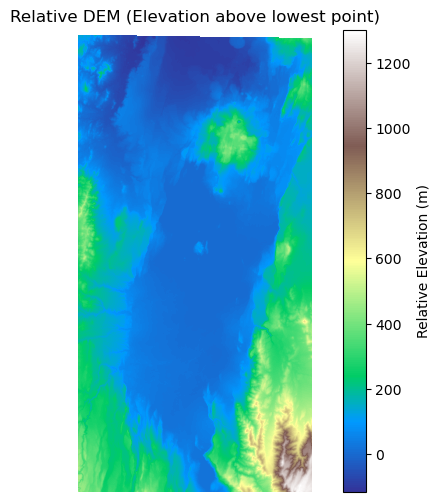

In [ ]:

plt.figure(figsize=(8,6))
cmap = 'terrain'  
im = plt.imshow(relative_dem_, cmap=cmap)
plt.colorbar(im, label='Relative Elevation (m)')
plt.title("Relative DEM (Elevation above lowest point)")
plt.axis('off')
plt.show()

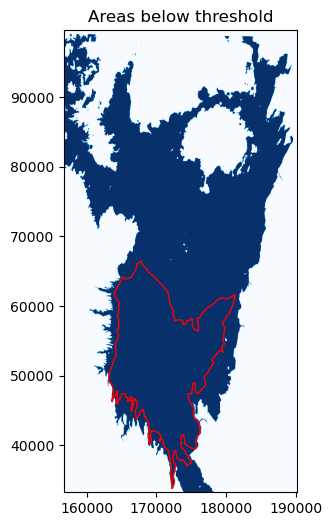

In [ ]:
with rasterio.open(out_dem_path) as src:
    relative_dem = src.read(1)
    flat_mask = (relative_dem >= 0) & (relative_dem <= 110)
    bounds = src.bounds  # capture bounds for extent

plt.figure(figsize=(8, 6))
ax = plt.gca()  # get current axis

# Plot the flat_mask raster
plt.imshow(flat_mask, cmap='Blues', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], origin='upper')

# Overlay the marigat shapefile
marigat_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)

plt.title("Areas below threshold")
#plt.axis('off')
plt.show()


In [ ]:
# Output path
out_mask_path = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data\Regression datasets\masked_relativeDEM.tif"

with rasterio.open(out_dem_path ) as src:
    profile = src.profile.copy()
    relative_dem = src.read(1)

    # Handle no data values
    nodata_val = src.nodata
    if nodata_val is not None:
        relative_dem = np.where(relative_dem == nodata_val, np.nan, relative_dem)

    # Apply threshold
    flat_mask = ((relative_dem >= 0) & (relative_dem <= 200)).astype(np.uint8)

    # Set profile for uint8 with nodata=0
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw',
        nodata=0
    )

    # Write to file
    with rasterio.open(out_mask_path, 'w', **profile) as dst:
        dst.write(flat_mask, 1)


#### S2 imagery

In [5]:
# Function to mask clouds in S2 Harmonized
def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
           qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask)

# Function to get annual composite
def get_s2_annual(year, max_cloud_pct=20):
    collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterBounds(study_area)
                  .filterDate(f'{year}-01-01', f'{year}-12-31')
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_pct))
                  .map(mask_s2_clouds)
                  .map(clip_to_aoi))
    return collection.median()

In [6]:
# Loop over years and export
for year in range(2015, 2026):
    print(f"Processing year: {year}")
    s2_image = get_s2_annual(year)
    export_image_to_drive(s2_image, year, label='S2_composite', folder='S2_Annual')

Processing year: 2015
Export started: S2_composite_2015
Processing year: 2016
Export started: S2_composite_2016
Processing year: 2017
Export started: S2_composite_2017
Processing year: 2018
Export started: S2_composite_2018
Processing year: 2019
Export started: S2_composite_2019
Processing year: 2020
Export started: S2_composite_2020
Processing year: 2021
Export started: S2_composite_2021
Processing year: 2022
Export started: S2_composite_2022
Processing year: 2023
Export started: S2_composite_2023
Processing year: 2024
Export started: S2_composite_2024
Processing year: 2025
Export started: S2_composite_2025
